In [2]:
import os
import sys
sys.path.insert(1, '../src/')
import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
TRAIN_RAW_DIR = os.path.join(config.INPUT_DIR, 'train.csv')
train_raw = pd.read_csv(TRAIN_RAW_DIR)
train_raw.sample(10)

,id,keyword,location,text,target
6425,9187,suicide%20bomber,NaN,Suicide bomber kills 15 in Saudi security site...,1
1689,2438,collide,"Vancouver, BC",#Vancouver to host 100s of electronic art even...,0
4531,6443,injured,Florida,Experienced urogyn trying to help mesh injured...,1
5827,8320,rubble,United States,China's Stock Market Crash: Are There Gems In ...,0
1022,1484,body%20bags,United Kingdom,Womens Buckle Casual Stylish Shoulder Handbags...,0
7493,10720,wreck,"Gwersyllt, Wales",Don't think I Can take anymore emotional wreck...,0
4760,6773,lightning,"Victoria, BC",Lightning causes six new fires on VancouveråÊI...,1
2590,3718,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
5307,7580,outbreak,Anywhere,Families to sue over Legionnaires: More than 4...,1
3364,4819,evacuation,Washington,Roosevelt Wash. under evacuation order due to ...,1


In [5]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


We have some null values here an there for keywords and location. Let's see whether missingness can bear useful information.

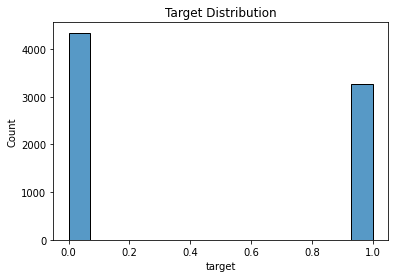

In [18]:
# for all of the data the target is distributed as follows:
sns.histplot(train_raw['target']).set_title('Target Distribution');

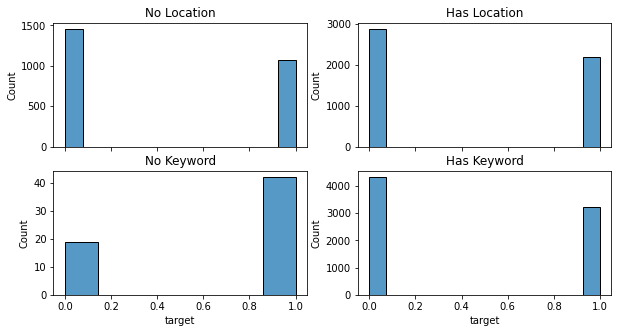

In [19]:
train_raw.loc[:,'is_location_missing'] = train_raw['location'].apply(lambda x: pd.isna(x))
train_raw.loc[:,'is_keyword_missing'] = train_raw['keyword'].apply(lambda x: pd.isna(x))
fig, axes = plt.subplots(2, 2, figsize  = (10, 5), sharex=True)
sns.histplot(ax = axes[0,0], data=train_raw.loc[train_raw['is_location_missing'] == True, 'target']).set_title('No Location')
sns.histplot(ax = axes[0,1], data=train_raw.loc[train_raw['is_location_missing'] == False, 'target']).set_title('Has Location')
sns.histplot(ax = axes[1,0], data=train_raw.loc[train_raw['is_keyword_missing'] == True, 'target']).set_title('No Keyword')
sns.histplot(ax = axes[1,1], data=train_raw.loc[train_raw['is_keyword_missing'] == False, 'target']).set_title('Has Keyword');

In [25]:

train_raw['text'].head(30).values

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
       '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
       '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
       "I'm on top of the hill and I can see a fire in the woods...",
       "There's an emergency evacuation happening now in the building across the street",
       "I'm afraid that the tornado is coming to our area...",
       'Three people died from the heat wave so far',
       'Haha South Tampa is getting flooded hah-

# Text Cleaning

Any language model would require us to conduct some text cleaning, For example in the texts above we see some noticable characteristics(or however we want to refer to them).

Just to name a few, we see:
- hashtags (#Alaska),
- lowercase and UPPERCASE, and CamelCase,
- numbers(80, 18, 19),
- punctuations(=>-! ,...), 
- abbreviations (I've, Hwy)
- non-dictionary words, yet very much understandable by a human(Cooool, LOOOOOL, goooooooaaaaaal)
- ... 

If look further in the data, we for sure also find *typos*, and many other weird things, that are most probably very easy for a human to understand.

Formulating the textual features highly depends on the approach we adopt and of course the data at hand. For example, many language tasks converting everything to a lowercase has become a automatic habit; however the letter case is really intertwined with the awe that people express when see something disasterous. 


In [44]:
def has_2plus_caps(text):
    #to strip spaces at margins
    text = text.strip()
    # to split them into words
    words = text.split()
    #run through all words
    for word in words:
        upper_count = 0
        for letter in word:
            if letter.isupper():
                upper_count += 1
                if upper_count > 2:
                    # if more than 2 caps in a word assume a word is capped
                    return True
    return False
def num_2plus_cap_words(text):
    #to strip spaces at margins
    text = text.strip()
    # to split them into words
    words = text.split()
    #run through all words
    cap_word_counts = 0
    for word in words:
        upper_count = 0
        for letter in word:
            if letter.isupper():
                upper_count += 1
                if upper_count > 2:
                    # if more than 2 caps in a word assume a word is capped
                    cap_word_counts += 1
                    break;
    return cap_word_counts

train_raw.loc[:, 'has_2plus_caps'] = train_raw['text'].apply(lambda x: has_2plus_caps(x))
train_raw.loc[:, 'num_2plust_cap_words'] = train_raw['text'].apply(lambda x: num_2plus_cap_words(x))

<AxesSubplot:xlabel='target', ylabel='count'>

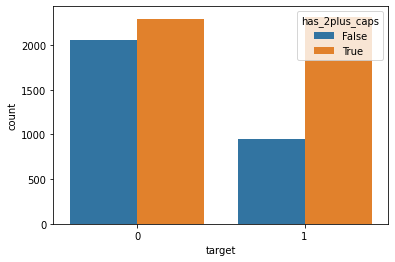

In [62]:
sns.countplot(x = 'target', hue = 'has_2plus_caps', data=train_raw)

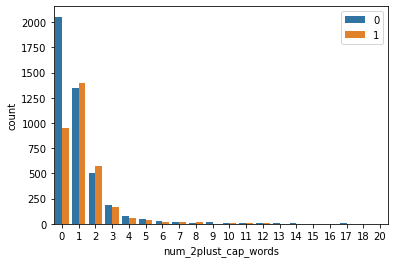

In [61]:
sns.countplot(x = 'num_2plust_cap_words', hue = 'target', data=train_raw);
plt.legend(loc='upper right')


The graphs and functions above are far from perfect, but just to illustrate a point. I did that because I did not want to impose any cleaning yet. But it suggests that the mere possession of all-caps induces more chance of a tweet being related to a distaster.

Let's also try to do the same for consecutive characters.

<AxesSubplot:xlabel='target', ylabel='count'>

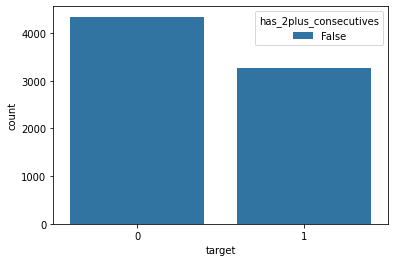

In [87]:
from itertools import groupby
def has_2plus_consectives(text):
    #to strip spaces at margins
    text = text.strip()
    # to split them into words
    words = text.split()
    #run through all words
    word_has_consecutives = False
    for word in words:
        groups = groupby('word')
        word_has_consecutives = any(count > 3 for count in [sum(1 for _ in group) for label, group in groups])
        if word_has_consecutives:
            return True
    return word_has_consecutives
train_raw.loc[:, 'has_2plus_consecutives'] = train_raw['text'].apply(lambda x: has_2plus_consectives(x))
sns.countplot(x = 'target', hue = 'has_2plus_consecutives', data=train_raw)


This one not so much. Engineering new features can be always be very helpful, and we can let the model decide for that. Such features can be fed into some machine learning classification algorithms, such as NaiveBayes, SVM, Logit, RandomForest, ... . But in this work I want to use the power of neural network/deep learning techniques to classify the text, and make use of the powerful ideas that give clues about the context, semantics, and the language specific structures to help classify tweets.

The features we created can be also used and become part of the full model.

